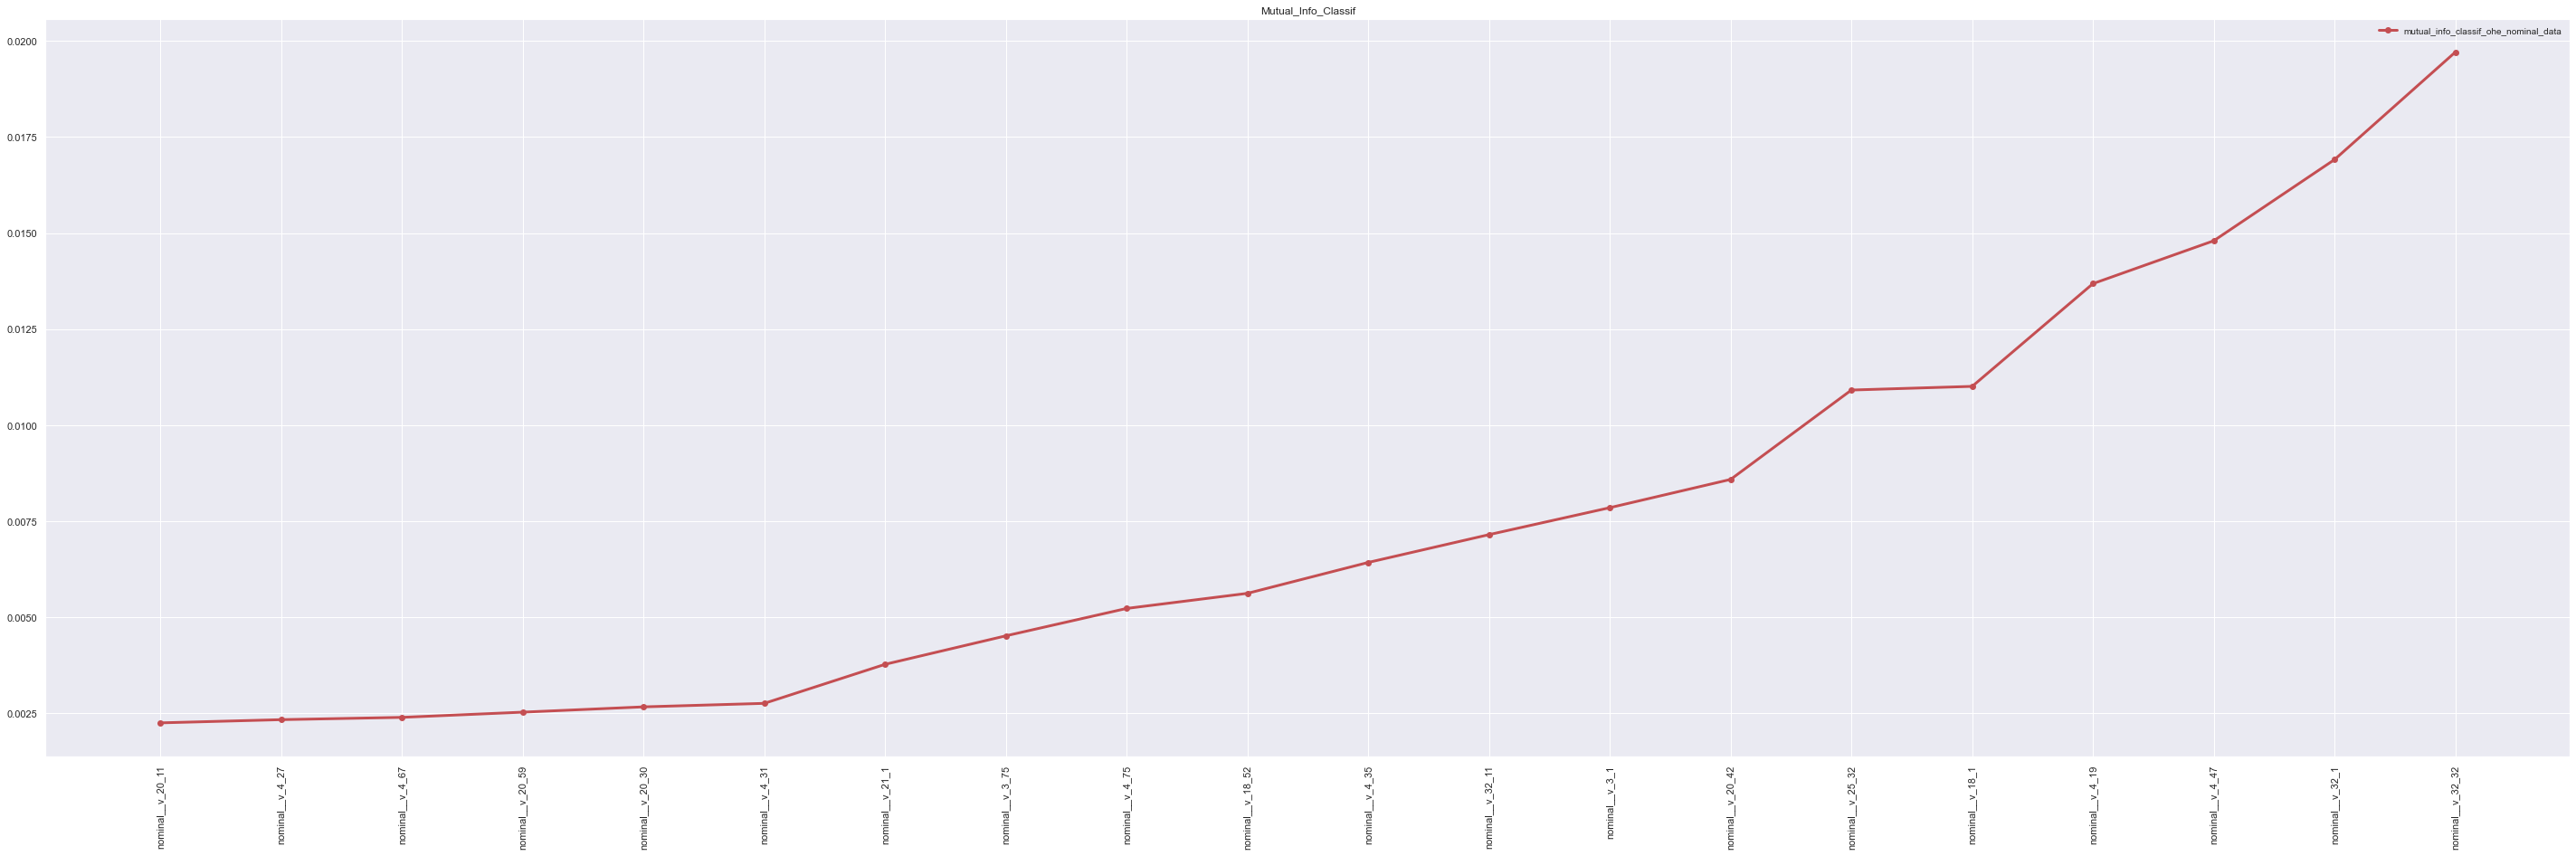

In [8]:
m_info_clf = mutual_info_classif(
    X=n1df, y=target, discrete_features=True, random_state=42
)
__featureOrder = m_info_clf.argsort()
fig, ax = plt.subplots(1, 1, figsize=(50, 15))
plt.style.use("seaborn")
plt.rcParams["font.size"] = 16
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["lines.linewidth"] = 3
plt.xticks(rotation=90)
ax.plot(
    n1df.columns[__featureOrder][-20:],
    m_info_clf[__featureOrder][-20:],
    "-ro",
    label="mutual_info_classif_ohe_nominal_data",
)
ax.legend()
disp = ax.set_title("Mutual_Info_Classif")

In [ ]:
scf = {"f_clf": f_classif, "chi2": chi2}
alpha_ = 0.12
k_best = 70
# class f_selection_party:
all_selectors = {}


def update_selectors(alpha_, k_best):
    global all_selectors
    for criterion, _scf in scf.items():
        selectors = [
            SelectFpr(
                chi2,
            ),
            SelectFdr(chi2),
            SelectFwe(chi2),
            SelectKBest(chi2, k=k_best),
            SelectFwe(chi2),
        ]
        for slctr in selectors:
            all_selectors[criterion + "-" + slctr.__class__.__name__] = slctr


update_selectors(alpha_=alpha_, k_best=k_best)
# feature_selection = Pipeline([("feature_selector", )])
feature_selection = FeatureUnion(
    transformer_list=list(all_selectors.items()), n_jobs=-1
)
feature_selection

In [ ]:
import plotly.express as px
import plotly.figure_factory as ff

m_info_clf = mutual_info_classif(
    X=n1df, y=target, discrete_features=True, random_state=42
)
f_info = dict(
    zip(
        n1df.columns,
        m_info_clf,
    )
)
micdf = pd.DataFrame(m_info_clf, columns=["M_I_C"], index=n1df.columns)
# px.histogram(micdf,marginal='rug',color_discrete_map=px.colors.sequential.Plasma)
disp = micdf.plot(kind="density", backend="matplotlib")
disp = micdf.plot(kind="hist", backend="matplotlib")

In [ ]:
chi2_f, chi2_p = chi2(X=n1df, y=target)  # ,discrete_features=True,random_state=42)
# f_info = dict(zip(n1df.columns,m_info_clf,))
# px.histogram(data_frame=chi2df,x='p',color='chi2', histnorm='probability

chi2df = pd.DataFrame(np.c_[chi2_f, chi2_p], columns=["chi2", "p"], index=n1df.columns)
# # px.histogram(micdf,marginal='rug',color_discrete_map=px.colors.sequential.Plasma)
# disp = micdf.plot(kind='density',backend='matplotlib')
# disp = micdf.plot(kind='hist',backend='matplotlib')

In [ ]:
chi2df[chi2df.p <= 0.12]

In [ ]:
X_train, X_test, y_train, y_test = train_test(n1df, target, 0.4)

In [ ]:
y_train.value_counts()

In [ ]:
def objective(trial: optuna.trial.Trial):
    rbm_params = {
        "batch_size": trial.suggest_int("rbm_batch_size", 5, 1000),
        "learning_rate": trial.suggest_float("rbm_learning_rate", 1e-03, 1),
        "n_components": trial.suggest_int("rbm_n_components", 3, 336),
        "n_iter": trial.suggest_int("rbm_epoch", 10, 100),
        "random_state": 42,
        "verbose": 0,
    }
    rbm = BernoulliRBM(**rbm_params)

In [60]:
ohe_nominal_feature_selection

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, sparse_threshold=0,
                                   transformers=[('one_hot_enc',
                                                  Pipeline(memory=Memory(location=None),
                                                           steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 min_frequency=0.0001,
                                                                                 sparse=False)),
                                                                  ('var_th',
                                                                   VarianceThreshold(threshold=0.001))]),
                                                  ['nominal__v_12',
                                                   'nominal__v_18',
                                                   'nominal__v_20',
                                                   'nominal__v_21',
                                                   'nominal_...
                                                 SelectPercentile(percentile=5,
                                                                  score_func=<function mutual_info_classif at 0x7f8dfdb43af0>)),
                                                ('F-SelectKBest',
                                                 SelectKBest(k=40)),
                                                ('F-SelectPercentile',
                                                 SelectPercentile(percentile=5)),
                                                ('CHI-SelectKBest',
                                                 SelectKBest(k=40,
                                                             score_func=<function chi2 at 0x7f8dfdb30c10>)),
                                                ('CHI-SelectPercentile',
                                                 SelectPercentile(percentile=5,
                                                                  score_func=<function chi2 at 0x7f8dfdb30c10>))]))])

In [61]:
with parallel_backend("loky"):
    elite_ohe_nominal_features_train = ohe_nominal_feature_selection.fit_transform(
        final_data, target
    )
    elite_ohe_nominal_features_test = ohe_nominal_feature_selection.transform(
        final_pred_data
    )
    f_names = ohe_nominal_feature_selection.get_feature_names_out()
    elite_onf_df = pd.DataFrame(elite_ohe_nominal_features_train, columns=f_names)
    elite_onf_df = (
        elite_onf_df.transpose()
        .drop_duplicates(
            ignore_index=False,
        )
        .transpose()
    )

    f_names_t = {
        x: x.split("__")[2] + "__" + x.split("__")[3] for x in elite_onf_df.columns
    }

    # elite_ohe_nominal_features_train = elite_ohe_nominal_features_train.transpose().drop_duplicates(ignore_index=False,).transpose()
    elite_onf_df.rename(columns=f_names_t, inplace=True)
    elite_onf_df_test = pd.DataFrame(elite_ohe_nominal_features_test, columns=f_names)
    elite_onf_df_test = (
        elite_onf_df_test.transpose()
        .drop_duplicates(
            ignore_index=False,
        )
        .transpose()
    )
    elite_onf_df_test.rename(columns=f_names_t, inplace=True)

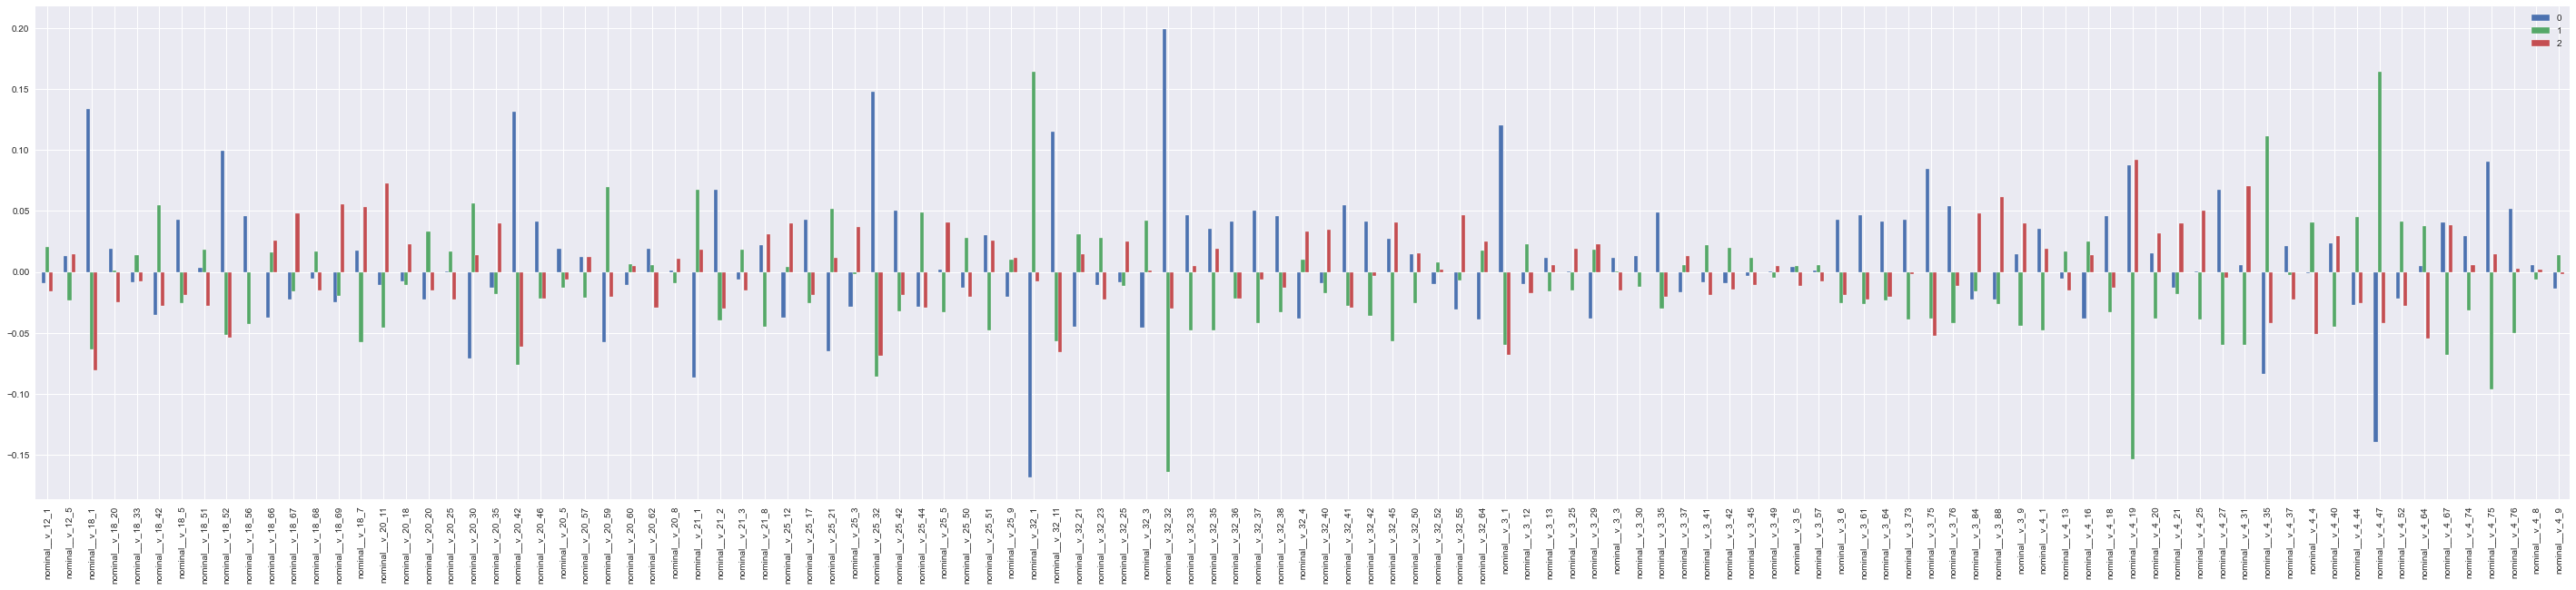

In [64]:
# n1df.loc[:,ch].corrwith(,method='kendall')
def multilabel_correlation(df: pd.DataFrame):
    multilabel_target = pd.get_dummies(target)
    co_0 = df.corrwith(multilabel_target[0], method="kendall")
    # print(f'co_0 min {co_0.var()}')
    # print(f'co_0 max {co_0.max()}')
    co_1 = df.corrwith(multilabel_target[1], method="kendall")
    # print(f'co_1 min {co_1.var()}')
    # print(f'co_1 max {co_1.max()}')
    co_2 = df.corrwith(multilabel_target[2], method="kendall")
    # print(f'co_2 min {co_2.var()}')
    # print(f'co_2 max {co_2.max()}')
    return pd.concat([co_0, co_1, co_2], axis=1)


multilabel_correlation(elite_onf_df).sort_index().plot(
    kind="bar", figsize=(50, 10), backend="matplotlib"
)
multilabel_correlation(n1df).plot(kind="bar")


def multiclass_correlation(df: pd.DataFrame):
    multiclass_target = target
    return df.corrwith(target, method="kendall")

In [361]:
ovr_bag.n_estimators

5

In [ ]:
import plotly.express as px
import plotly.figure_factory as ff

m_info_clf = mutual_info_classif(
    X=n1df, y=target, discrete_features=True, random_state=42
)
f_info = dict(
    zip(
        n1df.columns,
        m_info_clf,
    )
)
micdf = pd.DataFrame(m_info_clf, columns=["M_I_C"], index=n1df.columns)
# px.histogram(micdf,marginal='rug',color_discrete_map=px.colors.sequential.Plasma)
disp = micdf.plot(kind="density", backend="matplotlib")
disp = micdf.plot(kind="hist", backend="matplotlib")

In [ ]:
chi2_f, chi2_p = chi2(X=n1df, y=target)  # ,discrete_features=True,random_state=42)
# f_info = dict(zip(n1df.columns,m_info_clf,))
# px.histogram(data_frame=chi2df,x='p',color='chi2', histnorm='probability

chi2df = pd.DataFrame(np.c_[chi2_f, chi2_p], columns=["chi2", "p"], index=n1df.columns)
# # px.histogram(micdf,marginal='rug',color_discrete_map=px.colors.sequential.Plasma)
# disp = micdf.plot(kind='density',backend='matplotlib')
# disp = micdf.plot(kind='hist',backend='matplotlib')

In [ ]:
chi2df[chi2df.p <= 0.12]

In [ ]:
X_train, X_test, y_train, y_test = train_test(n1df, target, 0.4)

In [ ]:
y_train.value_counts()

In [ ]:
def objective(trial: optuna.trial.Trial):
    rbm_params = {
        "batch_size": trial.suggest_int("rbm_batch_size", 5, 1000),
        "learning_rate": trial.suggest_float("rbm_learning_rate", 1e-03, 1),
        "n_components": trial.suggest_int("rbm_n_components", 3, 336),
        "n_iter": trial.suggest_int("rbm_epoch", 10, 100),
        "random_state": 42,
        "verbose": 0,
    }
    rbm = BernoulliRBM(**rbm_params)

In [20]:
features_selected = {0: [], 1: [], 2: []}
selectors = {0: [], 1: [], 2: []}
feature_selection_df = {0: None, 1: None, 2: None}
feature_performance = {0: None, 1: None, 2: None}
improvements = {0: [], 1: [], 2: []}

In [ ]:
estimator = make_pipeline(
    VarianceThreshold(),
    LogisticRegression(
        solver="liblinear", n_jobs=-1, C=0.03, random_state=2, fit_intercept=False
    ),
)

try:
    idx = 0
    for X, y in tr_nom_db:
        X_train, X_test, y_train, y_test = train_test_split(
            enc_nom_df, y, test_size=0.3, random_state=42
        )
        vt = VarianceThreshold()
        print(f"Shape of data {X_train.shape}")
        __c = vt.fit_transform(X_train)
        print(f"Dim Reduction {X_train.shape[1]-__c.shape[1]}")

        # Baseline
        model = model_clone(estimator)
        model.fit(X_train, y_train)
        acc_init = sklearn.metrics.f1_score(
            model.predict(X_test), y_test, average="micro"
        )
        print(f"baseline f-1 score {acc_init}")
        print(f"Running SFS")
        with parallel_backend("loky"):
            # selector = SequentialFeatureSelector(model_clone(estimator),tol=0.001,n_features_to_select='auto',cv=RepeatedStratifiedKFold(n_splits=3,n_repeats=2),n_jobs=-1,scoring='f1_micro',)
            selector = RFEC(
                model_clone(estimator)[1],
                step=5,
                cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=2),
                n_jobs=-1,
                scoring="f1_micro",
            )
            selector.fit(enc_nom_df, y)
        new_data = selector.transform(enc_nom_df)
        print(f"SFS Dim Reduction {X_train.shape[1]-new_data.shape[1]}")

        X_train, X_test, y_train, y_test = train_test_split(
            new_data, y, test_size=0.3, random_state=42
        )
        model = model_clone(estimator)
        model.fit(X_train, y_train)
        acc_improved = sklearn.metrics.f1_score(
            model.predict(X_test), y_test, average="micro"
        )
        print(f"Improved By {acc_improved - acc_init} on {idx} Label")
        improvements[idx].append(acc_improved - acc_init)
        print(f"New F-1 Score {acc_improved}")
        idx += 1
except KeyboardInterrupt:
    print("Stopped Checking")
    # print(acc_improved)
    print(acc_init)

In [ ]:
sns.set()
# pd.options.plotting.backend = "matplotlib"
targets = pd.get_dummies(final_data.target)
f_sets_kendall = {}
f_sets_p = {}
for i in range(3):
    g1 = (
        final_data_indvl.drop(["target"], axis=1)
        .astype(np.float64)
        .corrwith(pd.get_dummies(final_data.target)[i], method="kendall")
        .sort_values()
    )
    g2 = g1[(g1 > 0) | (g1 < 0)]
    non_lin, lin = g1[g1 < 0].index, g1[g1 > 0].index
    f_sets_kendall[i] = (non_lin, lin)
    g1 = (
        final_data_indvl.drop(["target"], axis=1)
        .astype(np.float64)
        .corrwith(pd.get_dummies(final_data.target)[i], method="pearson")
        .sort_values()
    )
    g2 = g1[(g1 > 0) | (g1 < 0)]
    non_lin, lin = g1[g1 < 0].index, g1[g1 > 0].index
    f_sets_p[i] = (non_lin, lin)

In [ ]:
for k, v in f_sets_kendall.items():
    nl, l = f_sets_kendall[k]
    print(len(nl), len(l))

In [ ]:
# nd: pd.DataFrame = final_data.loc[:,nominal].astype('float')
# nd.corrwith(final_data.loc[:,binary+ordinal+ratio].astype('float'))
final_data_indvl.corr(method="kendall")

fi_indvl_corr = final_data_indvl.corr(method="kendall")

In [ ]:
# MAX 0.56


# Import Data and One Hot Encode with Drop First
final_data_indvl = pd.get_dummies(
    final_data_indvl, columns=nominal, drop_first=True, sparse=False, dtype=np.float64
)
mean_test_val_clf = defaultdict(list)
# model = NuSVC(nu=0.5,kernel='poly',degree=2,random_state=0)
mem = Memory("../data/tmp/")
for clf in tqdm(classifiers):
    nw_noms = list(
        set(final_data_indvl.columns)
        - set(binary)
        - set(ratio)
        - set(ordinal)
        - {"target"}
    )
    for _i in range(5, 150, 50):
        feature_agglomeration = FeatureAgglomeration(
            n_clusters=_i,
            affinity="euclidean",
            memory=mem,
            compute_full_tree=True,
            linkage="ward",
            compute_distances=True,
        )
        check = feature_agglomeration.fit_transform(
            final_data_indvl.loc[:, nw_noms].astype(np.float64)
        )
        with parallel_backend("loky"):
            # rpt = cross_validate(OneVsOneClassifier(NuSVC(nu=0.5,kernel='poly',degree=4,random_state=0)),check,final_data.target,cv=3,n_jobs=-1)
            try:
                rpt = cross_validate(
                    OneVsOneClassifier(clf),
                    check,
                    final_data.target,
                    cv=3,
                    n_jobs=-1,
                    scoring="f1_micro",
                )
            except:
                continue
            # rpt = cross_validate(OneVsOneClassifier(LogisticRegression(fit_intercept=False,n_jobs=-1,random_state=0)),check,final_data.target,cv=3,n_jobs=-1)
        mean_test_val_clf[clf.__class__.__name__].append(
            (_i, rpt["test_score"].mean(), rpt["test_score"].std())
        )


# sns.set()
# plot_agg_perf()
mean_test_val_clf

In [ ]:
# MAX 0.56


# Pipeline
final_data_indvl = pd.get_dummies(
    final_data_indvl, columns=nominal, drop_first=True, sparse=False, dtype=np.float64
)
nw_noms = list(
    set(final_data_indvl.columns) - set(binary) - set(ratio) - set(ordinal) - {"target"}
)
mem = Memory("../data/tmp3/")
mean_test_val_clf = defaultdict(list)
for clf in tqdm(classifiers):
    pipe = Pipeline(
        steps=[
            ("variancethreshold", VarianceThreshold()),
            ("rfecv", RFE(estimator=clf)),
            (clf.__class__.__name__, clf),
        ]
    )
    with parallel_backend("loky"):
        try:
            rpt = cross_validate(
                OneVsOneClassifier(pipe, n_jobs=-1),
                final_data_indvl.loc[:, nw_noms],
                final_data.target,
                cv=3,
                n_jobs=-1,
                scoring="f1_micro",
            )
        except:
            continue
        # rpt = cross_validate(OneVsOneClassifier(LogisticRegression(fit_intercept=False,n_jobs=-1,random_state=0)),check,final_data.target,cv=3,n_jobs=-1)
    mean_test_val_clf[clf.__class__.__name__].append(
        (rpt["test_score"].mean(), rpt["test_score"].std())
    )
mean_test_val_clf

In [ ]:
def plot_agg_perf(mean_test_val):
    plt.figure(figsize=(10, 5))
    # for i in range(3):
    c, mu, err = zip(*mean_test_val)
    nerr = np.asarray(mu) + -1 * np.asarray(err)
    perr = np.asarray(mu) + np.asarray(err)
    # perr = mu+err
    fi = plt.plot(c, perr)
    fi = plt.plot(c, mu, label=f"Mean Test Score in Label")
    fi = plt.plot(c, nerr)
    plt.fill_between(
        c, perr, nerr, "r", alpha=0.5, color="g", animated=True, cmap="inferno"
    )
    tg = plt.legend(loc="lower right")

In [ ]:
xgb_params = {
    "base_score": None,
    "booster": "gbtree",
    # 'colsample_bylevel': None,
    # 'colsample_bynode': None,
    # 'colsample_bytree': None,
    "gamma": 0,
    # 'gpu_id': None,
    "importance_type": "total_cover",
    # 'interaction_constraints': None,
    "learning_rate": 0.2,
    "eval_metric": "aucpr",
    "max_delta_step": None,
    # 'max_depth': 0,
    "min_child_weight": 1,
    # 'missing': np.nan,
    "monotone_constraints": None,
    "n_estimators": 100,
    # 'updater': 'grow_colmaker',
    "n_jobs": -1,
    "num_parallel_tree": None,
    "random_state": 42,
    "reg_alpha": None,
    "reg_lambda": None,
    "scale_pos_weight": None,
    "subsample": 0.5,
    "tree_method": "approx",
    "use_label_encoder": False,
    "validate_parameters": None,
    "verbosity": 1,
}
h2 = XGBClassifier(n_jobs=-1)


le = LabelEncoder()

# h1.fit(X,y)


# h1 = XGBClassifier(n_estimators=50,random_state=0,max_depth=30,n_jobs=-1,eval_metric='mlogloss')
h1 = XGBClassifier(n_jobs=-1)


fbc = FeatBoostClassifier(
    [
        h1,
        LogisticRegression(
            random_state=43,
            tol=0.00000001,
            max_iter=10000,
            n_jobs=-1,
            fit_intercept=False,
        ),
    ],
    number_of_folds=3,
    max_number_of_features=50,
    metric="f1",
    verbose=2,
    siso_ranking_size=20,
)
# fbc = FeatBoostClassifier(RandomForestClassifier(n_jobs=-1))

In [ ]:
with parallel_backend("loky"):
    fbc.fit(x__, y)

In [ ]:
x__ = final_data_indvl.loc[:, nw_noms].to_numpy()

In [ ]:
tx__ = fbc.transform(x__)

In [ ]:
lcv = LogisticRegressionCV(
    Cs=100,
    fit_intercept=False,
    cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3),
    dual=False,
    penalty="l2",
    scoring="f1_macro",
    solver="lbfgs",
    tol=0.0000000001,
    max_iter=10000,
    # class_weight=None,
    n_jobs=-1,
    verbose=0,
    refit=True,
    # intercept_scaling=1.0,
    multi_class="ovr",
    random_state=42,
    l1_ratios=np.linspace(0.0001, 0.9999, num=10),
)
lcv

In [195]:
medi = medi.loc[:, ["v_29", "v_22", "decimal_values_29", "decimal_values_22"]]

medi_29 = medi.sort_values(by="v_29", axis=0)

medi_29.sort_values(by="v_29", inplace=True)

tempdf = pd.DataFrame()

tempdf["v_29"] = medi_29.v_29 + medi_29.decimal_values_29

tempdf["v_22"] = medi_29.v_22 + medi_29.decimal_values_22

In [140]:
# # ordinal_data.columns

# ordinal_data.v_29 = data.v_29

# ordinal_data.v_22 = data.v_22

# ordinal_data = separate_floating_value(ordinal_data)

# nominal_data = nominal_data.astype(np.uint8)

# nominal_data.info()

In [212]:
# corr_dat = data.corr()
corr_dat.label

v_21    -0.042747
v_32    -0.099336
v_15     0.012123
v_4     -0.019453
v_1     -0.012368
v_8     -0.057983
v_12     0.010495
v_25    -0.076107
v_20    -0.045745
v_18     0.041063
v_3      0.064006
v_11    -0.000913
v_14    -0.005858
v_26    -0.036007
v_27     0.023907
v_30    -0.048670
v_9     -0.001762
v_31    -0.198527
v_28     0.004836
v_13    -0.006180
v_33     0.029574
v_17     0.098969
v_19     0.215180
v_29     0.297882
v_23    -0.019353
v_24    -0.030006
v_10     0.029318
v_5      0.147685
v_6      0.278750
v_22     0.373071
v_0     -0.035275
v_7     -0.041763
v_2     -0.045008
v_16     0.023932
v_34    -0.017565
v_35     0.006083
v_36     0.013118
v_37    -0.004187
v_38    -0.005791
v_39    -0.007229
v_40    -0.003273
label    1.000000
Name: label, dtype: float64

In [57]:
from pyvis.network import Network


adj_list = gen_adj_list(0.9, data=data)


# Adding Nodes
def addfnetnodes(nets, data):
    for c, f in enumerate(data.columns):
        colr = None
        if "nom" in f:
            colr = "#008000"
        elif "ord" in f:
            colr = "#800080"
        elif "bin" in f:
            colr = "#FFEC00"
        elif "label" in f:
            colr = "#D800FF"
        else:
            colr = "#FF0083"
        nets.add_node(c, label=f, shape="circle", color=colr)
    return nets


def addfnetedges(nt: Network, nnli):
    global adj_list
    corr_mat = data.corr()
    for nd in adj_list:
        if len(adj_list[nd]) > 0:
            for conn in adj_list[nd]:
                nt.add_edge(nnli[nd], nnli[conn], weight=corr_mat.loc[nd, conn])
    return nt


def draw_feature_network():
    global data, adj_list
    fnet = Network(
        notebook=False,
        heading="Clustering of Features",
        height="1080px",
        width="2000px",
        font_color="#46ff00",
        bgcolor="#9ed6c8",
    )
    fnet = addfnetnodes(fnet, data)
    nnli = {f["label"]: f["id"] for f in fnet.nodes}  #  net_node_label_ids
    fnet = addfnetedges(fnet, nnli)
    fnet.toggle_physics(True)
    fnet.set_options(
        """
        const options = {
        "edges": {
        "color": {
          "inherit": true
        },
        "selfReferenceSize": null,
        "selfReference": {
          "angle": 0.7853981633974483,
          "renderBehindTheNode": false
        },
        "smooth": {
          "type": "vertical",
          "forceDirection": "vertical"
        }
        },
        "interaction": {
        "hover": true,
        "multiselect": true,
        "navigationButtons": true
        },
        "manipulation": {
        "enabled": true,
        "initiallyActive": true
        },
        "physics": {
        "hierarchicalRepulsion": {
          "centralGravity": 0,
          "springLength": 440,
          "springConstant": 0,
          "nodeDistance": 90,
          "damping": 1,
          "avoidOverlap": 0.46
        },
        "maxVelocity": 1,
        "minVelocity": 0.01,
        "solver": "hierarchicalRepulsion",
        "timestep": 0.54,
        "wind": {
          "x": 0
        }
        }
        }
        """
    )
    return fnet

In [197]:
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3796 entries, 0 to 3795
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   v_1     3796 non-null   int64
 1   v_26    3796 non-null   int64
 2   v_11    3796 non-null   int64
 3   v_14    3796 non-null   int64
 4   v_30    3796 non-null   int64
 5   v_28    3796 non-null   int64
 6   v_9     3796 non-null   int64
 7   v_27    3796 non-null   int64
dtypes: int64(8)
memory usage: 266.9 KB


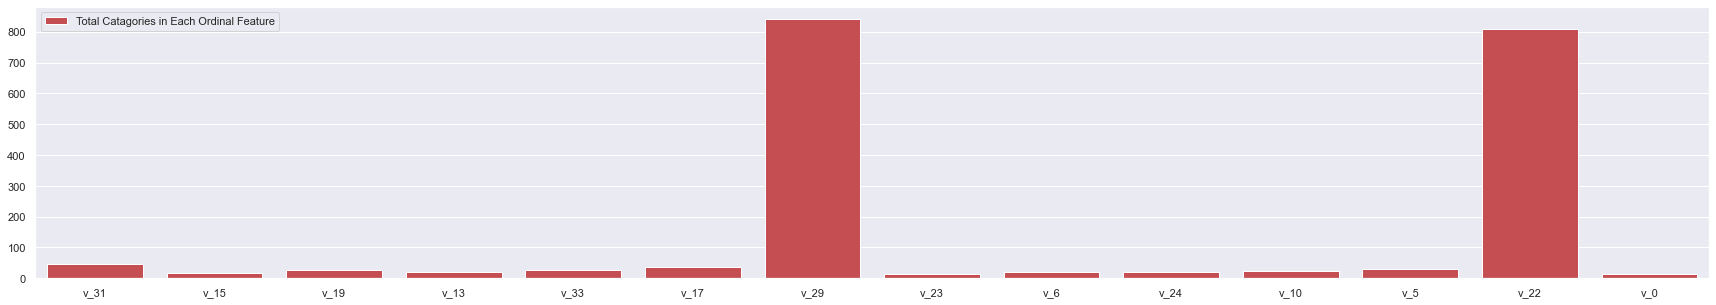

In [ ]:
categorical = ordinal + nominal
oridinal_categories_total = {}
for c in ordinal:
    # print(c, len(data[c].unique()))
    oridinal_categories_total[c] = len(data[c].unique())
fig = plt.figure(figsize=(30, 5))

fig = sns.barplot(
    x=ordinal,
    saturation=1,
    y=list(oridinal_categories_total.values()),
    label="Total Catagories in Each Ordinal Feature",
    color="r",
)
plt.legend()
# plt.table(ordinal)
plt.shor()

##### After Removing the decimal Part from the features

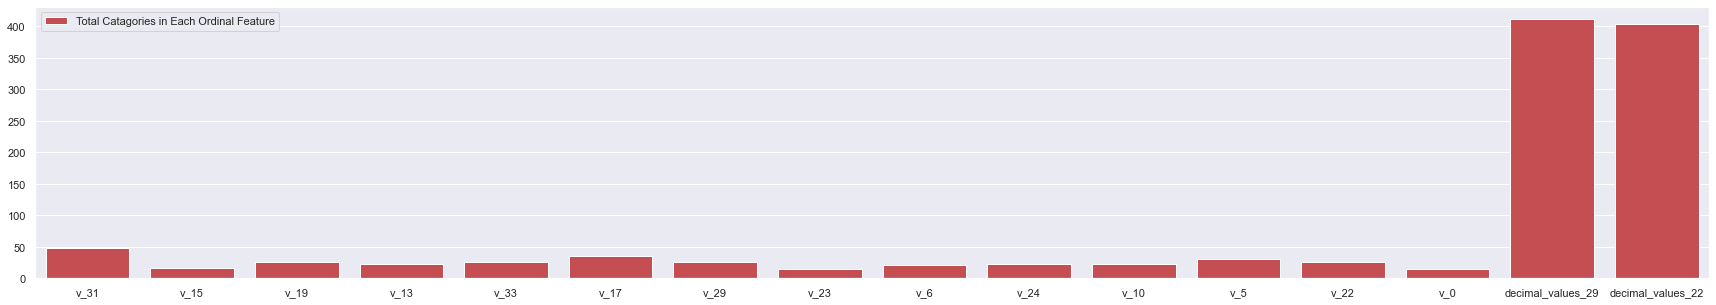

In [ ]:
categorical = ordinal + nominal
oridinal_categories_total = {}
for c in ordinal_data.columns:
    # print(c, len(data[c].unique()))
    oridinal_categories_total[c] = len(ordinal_data[c].unique())
fig = plt.figure(figsize=(30, 5))

fig = sns.barplot(
    x=ordinal_data.columns,
    saturation=1,
    y=list(oridinal_categories_total.values()),
    label="Total Catagories in Each Ordinal Feature",
    color="r",
)
# plt.table(ordinal)
# fig = plt.title
plt.xlabel = "After CLeanup"
fig = plt.legend()
fig = plt.show()

In [ ]:
# pd
temp = pd.DataFrame(
    oridinal_categories_total, columns=oridinal_categories_total.keys(), index=["count"]
)
temp.style

,v_31,v_15,v_19,v_13,v_33,v_17,v_29,v_23,v_6,v_24,v_10,v_5,v_22,v_0,decimal_values_29,decimal_values_22
count,48,17,26,22,26,36,26,14,21,22,23,30,26,15,411,403


In [ ]:
for c in ordinal_data.columns:
    if "decimal" not in c:
        ordinal_data[c] = ordinal_data[c].astype(np.uint8)

In [ ]:
# def print_num_cat(dd):
    for c in dd.columns:
        print(c,"\t|\t", len(dd[c].unique()))
        print("-"*30)

print("Binary")
print_num_cat(binary_data)
# print("-"*30)
print("\n"*4)

print("Nominal")
print_num_cat(nominal_data)
print("\n"*4)
print("Ordinal")
print_num_cat(ordinal_data)

In [ ]:
ordinal_data.decimal_values_22[ordinal_data.decimal_values_22! = 0].shape

(2496,)

In [ ]:
fig = plt.figure(figsize=(30, 10))

hm = sns.heatmap(data.corr())

In [ ]:
corr_mat = data.corr()

In [ ]:
training_target = data.label
df = data.drop(["label"], axis=1)
# len(df.columns)
corr_mat

In [196]:
ordinal_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3796 entries, 0 to 3795
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   v_31               3796 non-null   uint8  
 1   v_15               3796 non-null   uint8  
 2   v_19               3796 non-null   uint8  
 3   v_13               3796 non-null   uint8  
 4   v_33               3796 non-null   uint8  
 5   v_17               3796 non-null   uint8  
 6   v_29               3796 non-null   uint8  
 7   v_23               3796 non-null   uint8  
 8   v_6                3796 non-null   uint8  
 9   v_24               3796 non-null   uint8  
 10  v_10               3796 non-null   uint8  
 11  v_5                3796 non-null   uint8  
 12  v_22               3796 non-null   uint8  
 13  v_0                3796 non-null   uint8  
 14  decimal_values_29  3796 non-null   float64
 15  decimal_values_22  3796 non-null   float64
dtypes: float64(2), uint8(14)

In [178]:
# for c in ordinal+nominal:
#     data[c] = data[c].astype('category')
# Too soon

In [68]:
# data_ = pd.read_csv('../data/train.csv',index_col=0)